In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [3]:
def kill(cap=None):
    if cap:
        cap.release()
    cv2.destroyAllWindows()

In [57]:
def compute_stats(window):
    """Вычисляет среднее и стандартное отклонение для окна"""
    if window.size == 0:
        return 0, 0
    
    mean_val = np.mean(window)
    std_val = np.std(window)
    
    return mean_val, std_val

# Функция для получения увеличенного окна 11x11
def get_zoomed_window(image, x, y, window_size=11, zoom_factor=20):
    """Возвращает увеличенное окно 11x11 для отображения"""
    height, width = image.shape[:2]
    half_size = window_size // 2
    
    # Определяем границы окна
    x1 = max(0, x - half_size)
    y1 = max(0, y - half_size)
    x2 = min(width, x + half_size + 1)
    y2 = min(height, y + half_size + 1)
    
    # Получаем окно
    window = image[y1:y2, x1:x2]
    
    if not window.shape[2:]:
        padded_window = np.zeros((window_size, window_size), dtype=np.uint8)
        padded_window[0:window.shape[0], 0:window.shape[1]] = window
        window = padded_window
    # Если окно меньше 11x11 (у края изображения), дополняем черным
    elif window.shape[0] < window_size or window.shape[1] < window_size:
        padded_window = np.zeros((window_size, window_size, 3), dtype=np.uint8)
        padded_window[0:window.shape[0], 0:window.shape[1]] = window
        window = padded_window
    
    # Увеличиваем окно для лучшей видимости
    zoomed_window = cv2.resize(window, (window_size * zoom_factor, window_size * zoom_factor), 
                              interpolation=cv2.INTER_NEAREST)
    
    # Рисуем сетку на увеличенном окне
    for i in range(1, window_size):
        # Вертикальные линии
        cv2.line(zoomed_window, 
                (i * zoom_factor, 0), 
                (i * zoom_factor, window_size * zoom_factor), 
                (100, 100, 100), 1)
        # Горизонтальные линии
        cv2.line(zoomed_window, 
                (0, i * zoom_factor), 
                (window_size * zoom_factor, i * zoom_factor), 
                (100, 100, 100), 1)
    
    # Помечаем центральный пиксель
    center = (window_size // 2 * zoom_factor + zoom_factor // 2, 
             window_size // 2 * zoom_factor + zoom_factor // 2)
    cv2.circle(zoomed_window, center, 3, (0, 0, 255), -1)
    
    return zoomed_window

# Функция для обработки событий мыши
def mouse_callback(event, x, y, flags, param):
    """Обработчик событий мыши"""
    img, original_img, window_size, zoom_factor = param
    if event == cv2.EVENT_MOUSEMOVE:
        height, width = img.shape[:2]
        
        # Проверяем, что координаты в пределах изображения
        if 0 <= x < width and 0 <= y < height:
            # Получаем значения RGB текущего пикселя
            if len(img.shape) == 3:  # Цветное изображение
                b, g, r = img[y, x]
                intensity = (int(r) + int(g) + int(b)) / 3
            else:  # Черно-белое изображение
                r = g = b = img[y, x]
                intensity = r
            
            # Получаем окно 11x11 вокруг текущего пикселя
            half_size = window_size // 2
            x1 = max(0, x - half_size)
            y1 = max(0, y - half_size)
            x2 = min(width, x + half_size + 1)
            y2 = min(height, y + half_size + 1)
            
            window = img[y1:y2, x1:x2]
            
            # Вычисляем среднее и стандартное отклонение
            if len(img.shape) == 3:
                # Для цветного изображения вычисляем для каждого канала и берем среднее
                means = []
                stds = []
                for channel in range(3):
                    channel_window = window[:, :, channel]
                    mean_val, std_val = compute_stats(channel_window)
                    means.append(mean_val)
                    stds.append(std_val)
                mean_w = np.mean(means)
                std_w = np.mean(stds)
            else:
                mean_w, std_w = compute_stats(window)
            
            # Создаем копию изображения для отрисовки внешней рамки 13x13
            frame_img = original_img.copy()
            
            # Рисуем внешнюю рамку 13x13 (желтый цвет)
            outer_half_size = 6  # 13//2 = 6 (так как 13 нечетное)
            x1_outer = max(0, x - outer_half_size)
            y1_outer = max(0, y - outer_half_size)
            x2_outer = min(width, x + outer_half_size + 1)
            y2_outer = min(height, y + outer_half_size + 1)
            
            cv2.rectangle(frame_img, (x1_outer, y1_outer), (x2_outer-1, y2_outer-1), (0, 255, 255), 2)
            
            # Рисуем внутреннюю рамку 11x11 (красный цвет) для сравнения
            cv2.rectangle(frame_img, (x1, y1), (x2-1, y2-1), (0, 0, 255), 1)
            
            # Помечаем центральный пиксель
            cv2.circle(frame_img, (x, y), 3, (0, 0, 255), -1)
            
            # Получаем увеличенное окно 11x11
            zoomed_window = get_zoomed_window(original_img, x, y, window_size, zoom_factor)
            
            # Создаем изображение для отображения текста
            info_img = np.ones((200, 500, 3), dtype=np.uint8) * 255
            
            # Добавляем текст на изображение
            cv2.putText(info_img, f"Coordinates: ({x}, {y})", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            cv2.putText(info_img, f"RGB: R={r}, G={g}, B={b}", (10, 60), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            cv2.putText(info_img, f"Intensity: {intensity:.2f}", (10, 90), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            cv2.putText(info_img, f"Window Mean: {mean_w:.2f}", (10, 120), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            cv2.putText(info_img, f"Window Std: {std_w:.2f}", (10, 150), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            cv2.putText(info_img, "Yellow: 13x13 frame, Red: 11x11 window", (10, 180), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            
            # Показываем изображения
            # cv2.imshow('Image with Frame', frame_img)
            cv2.imshow('Zoomed 11x11 Window', zoomed_window)
            cv2.imshow('Pixel Information', info_img)

In [64]:
def show(img, text="",window_size=13, zoom_factor=20):
    if img is None:
        img = np.zeros((300, 400, 3), dtype=np.uint8)
        cv2.putText(img, 'OpenCV Demo', (50, 150), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    original_img = img.copy()
    cv2.imshow(text,img)
    
    cv2.setMouseCallback(text, mouse_callback, [img,original_img, window_size,zoom_factor])
    cv2.waitKey(0)
    kill()

In [65]:
image = cv2.imread("lenna.jpg")
if image is None:
        image = np.zeros((300, 400, 3), dtype=np.uint8)
        cv2.putText(image, 'OpenCV Demo', (50, 150), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        print("Created sample image")

In [66]:
show(image)

In [16]:
def grayscale(img):
    image = (0.2125*img[:,:,0] + 0.7154*img[:,:,1] + 0.0721*img[:,:,2]).astype(np.uint8)
    # image = (0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2])
    return image

def R(img):
    image = img[:,:,0]
    return image

def G(img):
    image = img[:,:,1]
    return image

def B(img):
    image = img[:,:,2]
    return image

In [17]:
# grayscale(image)
# plt.imshow(grayscale(image), cmap="gray")
# plt.axis("off")

In [18]:
gray = grayscale(image)
red = R(image)
green = G(image)
blue = B(image)

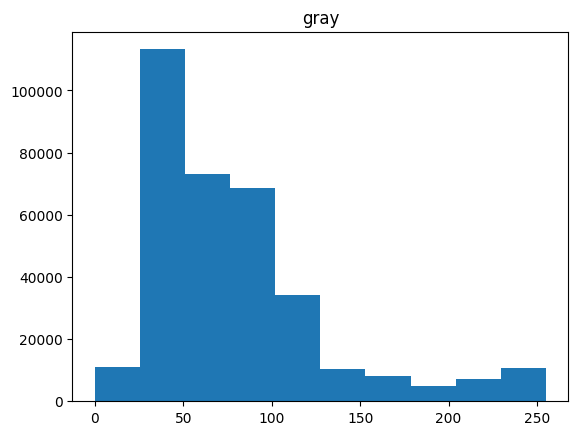

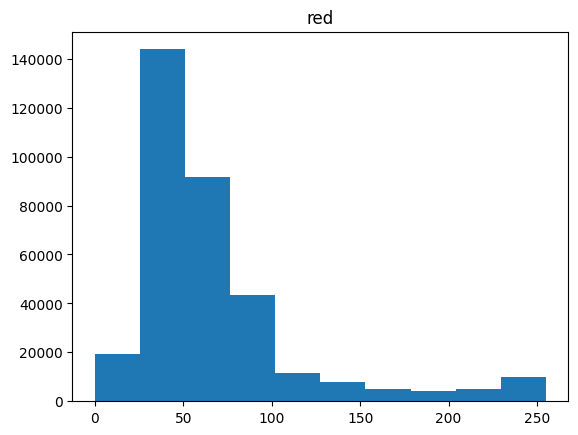

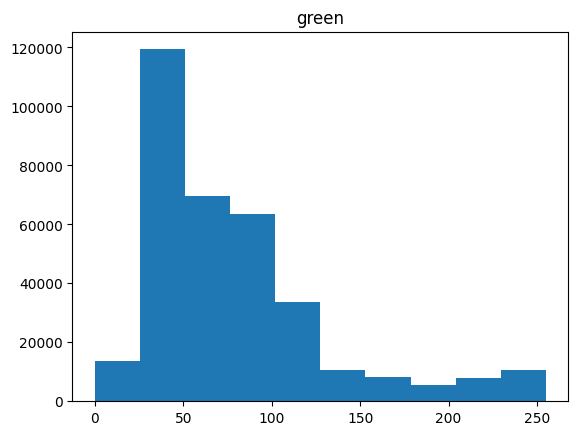

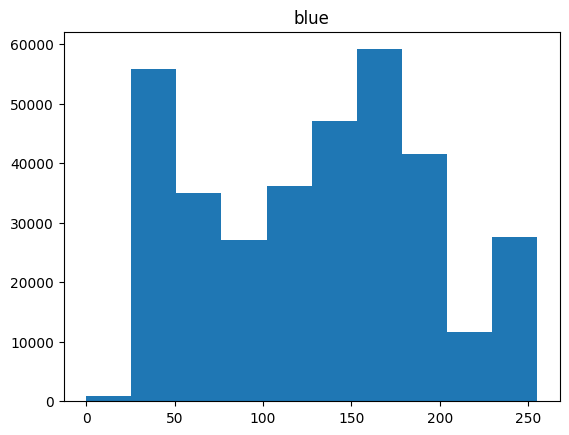

In [59]:
for color,item in (["gray",gray], ["red",red], ["green",green], ["blue", blue]):
    show(item, text=color)
    plt.figure()
    plt.hist(item.flatten())
    plt.title(color)